In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [103]:
all_out = glob("out/**/*.pkl")

In [104]:
all_out = [load_pickle(p) for p in all_out]

In [105]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [106]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [107]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(["mean", "std", sem])

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

In [108]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [109]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [110]:
grouped_res.loc[2, :]

frac_valid            accuracy                      \
                                mean  std  sem      mean       std       sem   
representation train_size                                                      
inchi          10                1.0  0.0  0.0  0.584000  0.039598  0.028000   
               50                1.0  0.0  0.0  0.734000  0.036770  0.026000   
               100               1.0  0.0  0.0  0.848000  0.005657  0.004000   
               200               1.0  NaN  NaN  0.868000       NaN       NaN   
iupac_name     10                1.0  0.0  0.0  0.582000  0.065054  0.046000   
               50                1.0  0.0  0.0  0.670000  0.042426  0.030000   
               100               1.0  0.0  0.0  0.862000  0.025456  0.018000   
               200               1.0  NaN  NaN  0.836000       NaN       NaN   
selfies        10                1.0  0.0  0.0  0.680000  0.028284  0.020000   
               50                1.0  0.0  0.0  0.784000  0.022627  0.016000   
               100               1.0  0.0  0.0  0.856000  0.039598  0.028000   
               200               1.0  NaN  NaN  0.908000       NaN       NaN   
smiles         10                1.0  0.0  0.0  0.541333  0.070238  0.040552   
               50                1.0  0.0  0.0  0.752000  0.011314  0.008000   
               100               1.0  0.0  0.0  0.860000  0.016971  0.012000   
               200               1.0  NaN  NaN  0.896000       NaN       NaN   

                           f1_macro                      f1_micro            \
                               mean       std       sem      mean       std   
representation train_size                                                     
inchi          10          0.567827  0.062250  0.044018  0.584000  0.039598   
               50          0.732498  0.035182  0.024877  0.734000  0.036770   
               100         0.847636  0.006168  0.004361  0.848000  0.005657   
               200         0.867981       NaN       NaN  0.868000       NaN   
iupac_name     10          0.559575  0.096355  0.068133  0.582000  0.065054   
               50          0.669431  0.043224  0.030564  0.670000  0.042426   
               100         0.861973  0.025450  0.017996  0.862000  0.025456   
               200         0.835976       NaN       NaN  0.836000       NaN   
selfies        10          0.671383  0.018892  0.013358  0.680000  0.028284   
               50          0.783363  0.023075  0.016317  0.784000  0.022627   
               100         0.855810  0.039801  0.028144  0.856000  0.039598   
               200         0.907928       NaN       NaN  0.908000       NaN   
smiles         10          0.528683  0.072061  0.041604  0.541333  0.070238   
               50          0.750614  0.009562  0.006762  0.752000  0.011314   
               100         0.859885  0.017029  0.012041  0.860000  0.016971   
               200         0.895893       NaN       NaN  0.896000       NaN   

                                        kappa                      
                                sem      mean       std       sem  
representation train_size                                          
inchi          10          0.028000  0.168000  0.079196  0.056000  
               50          0.026000  0.468000  0.073539  0.052000  
               100         0.004000  0.696000  0.011314  0.008000  
               200              NaN  0.736000       NaN       NaN  
iupac_name     10          0.046000  0.164000  0.130108  0.092000  
               50          0.030000  0.340000  0.084853  0.060000  
               100         0.018000  0.724000  0.050912  0.036000  
               200              NaN  0.672000       NaN       NaN  
selfies        10          0.020000  0.360000  0.056569  0.040000  
               50          0.016000  0.568000  0.045255  0.032000  
               100         0.028000  0.712000  0.079196  0.056000  
               200              NaN  0.816000      

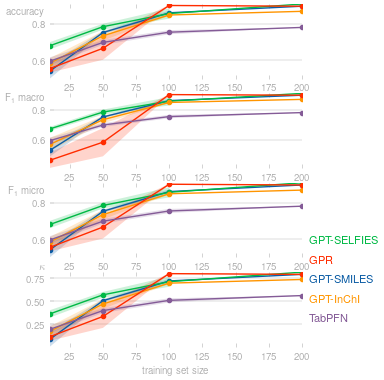

In [111]:
# plot the binary case, i.e. num_classes = 2
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))
    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "smiles", :].index,
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            - grouped_res.loc[2, "smiles", :][metric]["sem"],
            grouped_res.loc[2, "smiles", :][metric]["mean"]
            + grouped_res.loc[2, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "selfies", :].index,
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            - grouped_res.loc[2, "selfies", :][metric]["sem"],
            grouped_res.loc[2, "selfies", :][metric]["mean"]
            + grouped_res.loc[2, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "inchi", :].index,
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            - grouped_res.loc[2, "inchi", :][metric]["sem"],
            grouped_res.loc[2, "inchi", :][metric]["mean"]
            + grouped_res.loc[2, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            - grouped_xgboost_res.loc[2, :][metric]["sem"],
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            + grouped_xgboost_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, :][metric]["sem"],
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    ax[-1].set_xlabel("training set size", labelpad=4)

    fig.savefig("freesolv-classification_results_binary.pdf", bbox_inches="tight")

In [146]:
find_learning_curve_intersection(
    grouped_res.loc[2, "selfies", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:383: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c


4.257238537131607

In [148]:
find_learning_curve_intersection(
    grouped_res.loc[2, "selfies", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.4628933054552782

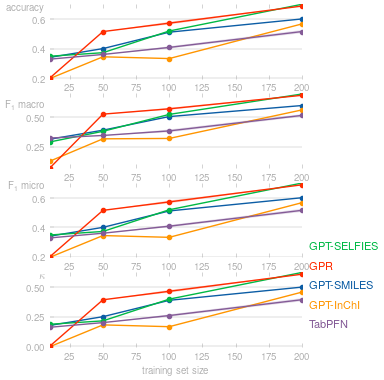

In [112]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "smiles", :].index,
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            - grouped_res.loc[5, "smiles", :][metric]["sem"],
            grouped_res.loc[5, "smiles", :][metric]["mean"]
            + grouped_res.loc[5, "smiles", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "selfies", :].index,
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            - grouped_res.loc[5, "selfies", :][metric]["sem"],
            grouped_res.loc[5, "selfies", :][metric]["mean"]
            + grouped_res.loc[5, "selfies", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "inchi", :].index,
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            - grouped_res.loc[5, "inchi", :][metric]["sem"],
            grouped_res.loc[5, "inchi", :][metric]["mean"]
            + grouped_res.loc[5, "inchi", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    ax[-1].set_xlabel("training set size", labelpad=4)
    fig.savefig("freesolv-classification_results_5_class.pdf", bbox_inches="tight")